In [1]:
import KGInt as kg
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from ipyparallel import Client

%matplotlib inline

In [159]:
def integrateC3(k):
    d = "/gpfs/mnt/gpfs02/phenix/plhf/plhf1/abagoly/workdir/HBTCoulombCorrection"
    import sys
    sys.path.append(d)
    import KGInt as kg
    import numpy as np
    import h5py as h5
    
    f = h5.File(d+"/Levy.h5", "r")

    limits = f["limits"]["999"].value
    alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)
    dr     = f["dr"]["999"].value

    l = kg.Levyd(1., 2.0, limits[0], limits[1], dr, f["Lr"]["999"].value, 1e-8)

    c3 = kg.Coulomb3d(l)

    return c3.integrate(k, k, k, int(1e8))

def integrateC3Full(k):
    d = "/gpfs/mnt/gpfs02/phenix/plhf/plhf1/abagoly/workdir/HBTCoulombCorrection"
    import sys
    sys.path.append(d)
    import KGInt as kg
    import numpy as np
    import h5py as h5
    
    f = h5.File(d+"/Levy.h5", "r")

    limits = f["limits"]["999"].value
    alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)
    dr     = f["dr"]["999"].value

    l = kg.Levyd(1., alphas[999], limits[0], limits[1], dr, f["Lr"]["999"].value, 1e-8)

    c3 = kg.Coulomb3d(l)
    
    td = "/gpfs/mnt/gpfs02/phenix/plhf/plhf1/abagoly/workdir/HBTCoulombCorrection/tmp/"

    iii = c3.integrateFull(k, k, k, int(1e9))
    
    file = open(td+"k_"+str(k), "w")
    file.writelines([str(iii)])
    file.close()
    
    return iii

def integrateC2(k):
    d = "/gpfs/mnt/gpfs02/phenix/plhf/plhf1/abagoly/workdir/HBTCoulombCorrection"
    import sys
    sys.path.append(d)
    import KGInt as kg
    import numpy as np
    import h5py as h5
    
    f = h5.File(d+"/Levy.h5", "r")

    limits = f["limits"]["999"].value
    alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)
    dr     = f["dr"]["999"].value

    l = kg.Levyd(1., alphas[999], limits[0], limits[1], dr, f["Lr"]["999"].value, 1e-8)

    c2 = kg.Coulomb2d(l)

    r = c2.integrate(k, 2*int(1e7))
    return r*r*r

In [160]:
client = Client(profile="condor")
dv = client[:]
len(client.ids)

145

In [162]:
N       = 145
workers = len(client.ids)

if np.ceil(N/workers)!=np.floor(N/workers):
    print("number of nodes not compatible with the workers")

In [22]:
ks = np.concatenate((np.linspace(1.5, 15, 190), np.linspace(15,40, N-190)))

In [163]:
res_c3_full = dv.map_async(integrateC3Full, ks)

In [11]:
res_c3 = dv.map_async(integrateC3, ks)

In [187]:
2+0.127*300

40.1

In [129]:
res_c2 = dv.map_async(integrateC2, kval)

In [ ]:
res_c3_full.wait_interactive()

 109/145 tasks finished after 75319 s

In [10]:
c3_full = np.array(res_c3_full.get())

In [14]:
c3 = np.array(res_c3.get())

In [131]:
c2 = np.array(res_c2.get())

In [155]:
import os

kval = []
c3_val = []
for fn in os.listdir("tmp/f1"):
    if fn.find("f")!=-1:
        continue
    kval.append(float(fn.split("_")[1]))
    f = open("tmp/f1/"+fn,"r")
    c3_val.append(float(f.readline()))
    f.close()

In [156]:
def sort(k, v):
    for i in range(len(k)):
        for j in range(i, len(k)):
            if k[i]>k[j]:
                k[i], k[j] = k[j],k[i]
                v[i], v[j] = v[j],v[i]
    return (k,v)

In [112]:
kval, c3_val = sort(kval, c3_val)

In [142]:
for i in range(1,len(c3_val)):
    c3_val[i] = c3[i-1]

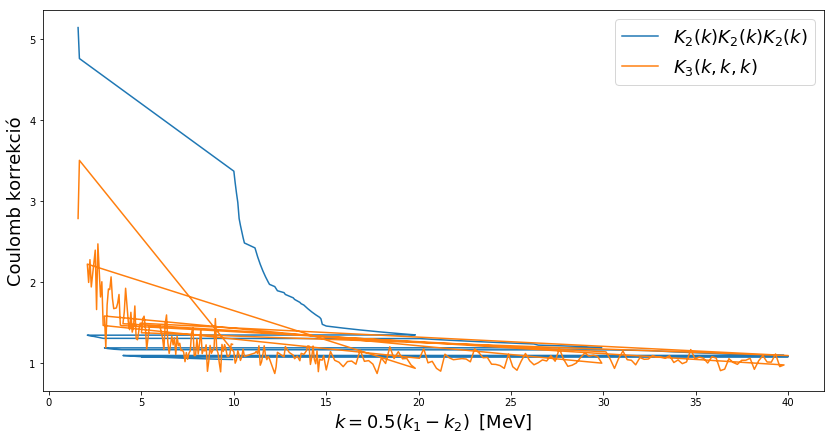

In [157]:
plt.figure(0,(14,7))
plt.xlabel(r"$k = 0.5(k_1-k_2)\;\;[\mathrm{MeV}]$", fontsize=18)
plt.ylabel("Coulomb korrekció", fontsize=18)
plt.plot(kval, c2, label=r"$K_2(k)K_2(k)K_2(k)$")
plt.plot(kval, c3_val, label=r"$K_3(k, k, k)$")
plt.legend(fontsize=18)

In [116]:
def make_smooth(v):
    r = np.zeros_like(v)
    r[0] = (2*v[0]+v[1])/3.
    for i in range(1, len(v)):
        if i==1:
            r[1] = (v[0]+2*v[1]+v[2])/4.
        elif i==(len(v)-2):
            r[i] = (v[i-2]+2*v[i-1]+3*v[i]+2*v[i+1])/8.
        elif i==(len(v)-1):
            r[i] = (v[i-1]+2*v[i])/3.
        else:
            r[i] = (v[i-2]+2*v[i-1]+3*v[i]+2*v[i+1]+v[i+2])/9.
    r[-2] = (v[-3]+2*v[-2]+v[-1])/4.
    return r

def mksmth(i, v):
    x = v
    for j in range(i):
        x = make_smooth(x)
    return x

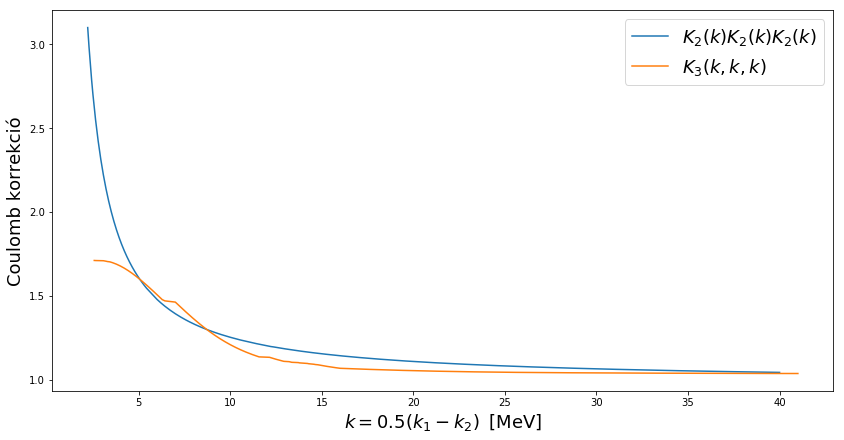

In [153]:
plt.figure(0,(14,7))
plt.xlabel(r"$k = 0.5(k_1-k_2)\;\;[\mathrm{MeV}]$", fontsize=18)
plt.ylabel("Coulomb korrekció", fontsize=18)
plt.plot(kval[4:], c2[4:], label=r"$K_2(k)K_2(k)K_2(k)$")
plt.plot(np.array(kval)+1, mksmth(1000,c3_val), label=r"$K_3(k, k, k)$")
#plt.plot(kval, s(kval), '.', label=r"$K_3(k, k, k)$")
plt.legend(fontsize=18)

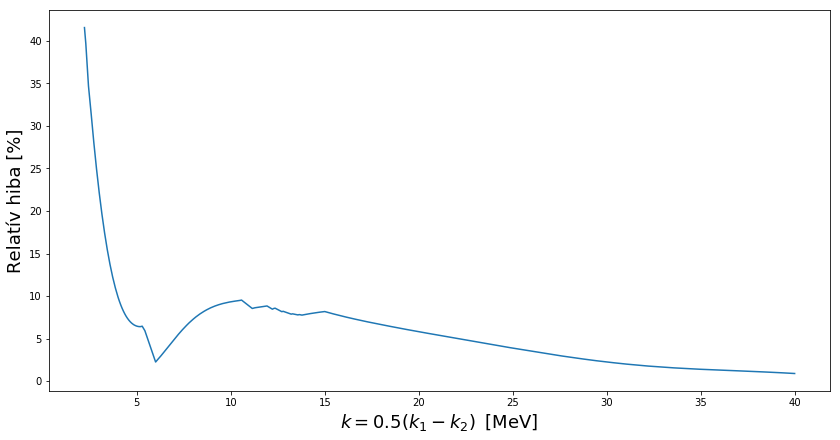

In [150]:
plt.figure(0,(14,7))
plt.xlabel(r"$k = 0.5(k_1-k_2)\;\;[\mathrm{MeV}]$", fontsize=18)
plt.ylabel("Relatív hiba [%]", fontsize=18)
plt.plot(kval[4:], ((c2-mksmth(500,c3_val))/make_smooth(c2))[4:]*100)
#plt.plot(kval, s(kval), '.', label=r"$K_3(k, k, k)$")
#plt.legend(fontsize=18)

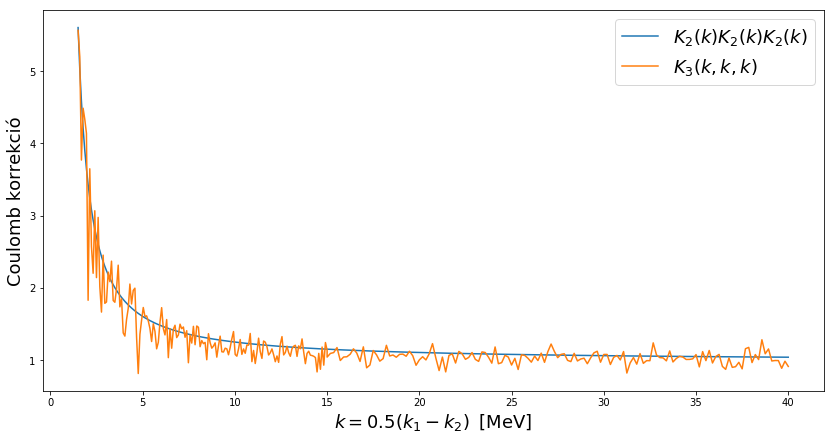

In [16]:
plt.figure(0,(14,7))
plt.xlabel(r"$k = 0.5(k_1-k_2)\;\;[\mathrm{MeV}]$", fontsize=18)
plt.ylabel("Coulomb korrekció", fontsize=18)
plt.plot(ks, c2, label=r"$K_2(k)K_2(k)K_2(k)$")
plt.plot(ks, c3_full, label=r"$K_3(k, k, k)$")
plt.legend(fontsize=18)